In [1]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells, extend_spells, gb_index
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import DataHandler, open_da, data_path, compute_anomalies_pl, coarsen_da, compute_anomalies_ds
from jetutils.definitions import (
    DATADIR,
    FIGURES,
    PRETTIER_VARNAME,
    YEARS,
    KAPPA,
    compute,
    get_region,
    infer_direction,
    polars_to_xarray,
    xarray_to_polars,
    labels_to_mask,
    extract_season_from_df,
    DUNCANS_REGIONS_NAMES,
    UNITS,
    N_WORKERS,
    do_rle,
    do_rle_fill_hole,
)
from jetutils.jet_finding import JetFindingExperiment, jet_integral_haversine, find_all_jets, haversine_from_dl, jet_position_as_da, add_normals, gather_normal_da_jets, average_jet_categories, connected_from_cross, get_double_jet_index, iterate_over_year_maybe_member, track_jets, average_jet_categories_v2
from jetutils.plots import COLORS, COLORS_EXT, PINKPURPLE, Clusterplot, gather_normal_da_jets_wrapper, _gather_normal_da_jets_wrapper, make_transparent, honeycomb_panel, plot_seasonal, interp_jets_to_zero_one
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from tqdm import tqdm
import polars.selectors as cs


%load_ext autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  225280


In [2]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    labels = labels.cast({"time": pl.Datetime("ms")})
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)

In [3]:
dh = DataHandler.from_specs("ERA5", "plev", "high_wind", "6H", "all", None, -80, 40, 15, 80)
exp = JetFindingExperiment(dh)
all_jets_one_df = exp.find_jets(force=False, alignment_thresh=0.6, base_s_thresh=0.55, int_thresh_factor=0.35, hole_size=10)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=5, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})

props_uncat = exp.props_as_df(False).cast({"time": pl.Datetime("ms")})
props_as_df = average_jet_categories(props_uncat, polar_cutoff=0.5)

summer_filter = summer.rename("time").to_frame()
props_summer = summer_filter.join(props_as_df, on="time")
ds = exp.ds

100%|██████████| 12/12 [00:28<00:00,  2.39s/it]


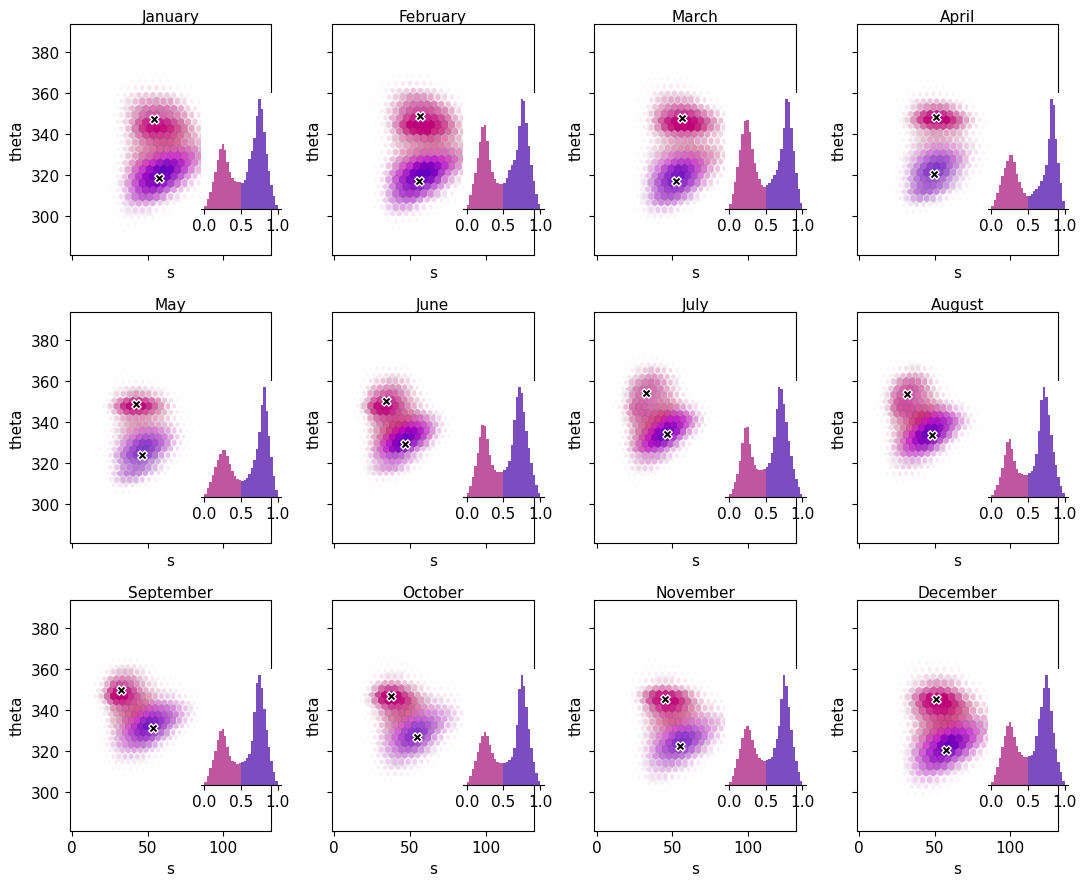

In [4]:
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
from tqdm import trange
from jetutils.jet_finding import extract_features
from jetutils.definitions import MONTH_NAMES

xys = []
all_jets = all_jets_one_df

xys = np.array(xys)
fig, axes = plt.subplots(3, 4, figsize=(11, 9), tight_layout=True, sharex="all", sharey="all")
axes = axes.ravel()
pair = ["s", "theta", "is_polar"]
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
bins = np.linspace(0, 1, 31)
for month in trange(1, 13):
    ax = axes[month - 1]
    X = extract_features(all_jets, pair, season=month)
    probas = X[pair[2]]
    center_stj = X.filter(pl.col("is_polar") < 0.3).mean()
    center_edj = X.filter(pl.col("is_polar") > 0.7).mean()
    X1D = X["is_polar"]
    
    im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
    im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=probas, cmap=colormaps.gray_r, gridsize=25)
    
    plt.draw()
        
    offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
    offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
    mask12 = np.isin(offsets1, offsets2)
    colors = cmap(im2.get_array())
    colors = rgb_to_hsv(colors[:, :3])
    min_s, max_s = 0., 1.0
    min_v, max_v = 0.75, 1.
    scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
    f = lambda x: np.sqrt(x)
    colors[:, 1] = min_s + scaling * (max_s - min_s)
    colors[:, 2] = max_v - scaling * (max_v - min_v)
    colors = hsv_to_rgb(colors)
    im2.set_array(None)
    im2.set_facecolor(colors)
    # im2.set_linewidths(0.2)
    im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
    im2.set_edgecolor(colormaps.greys(scaling))
    im2 = ax.add_collection(im2)
        
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
        
    ax.set_title(MONTH_NAMES[month - 1])
    ax.scatter(*pl.concat([center_stj, center_edj])[pair[:2]].to_numpy().T, facecolor="black", edgecolor="white", marker="X", linewidths=1, s=45)
    iax = ax.inset_axes([0.65, 0.2, 0.4, 0.5])
    X1D = np.clip(X1D, 0, 1)
    iax.hist(X1D, bins=bins, alpha=0.5, color="black")
    iax.hist(X1D[probas > 0.5], bins=bins, alpha=0.5, color=COLORS[1])
    iax.hist(X1D[probas < 0.5], bins=bins, alpha=0.5, color=COLORS[2])
    iax.set_xticks([0, 0.5, 1])
    iax.set_yticks([])
    iax.spines[["left", "right", "top"]].set_visible(False)
    plt.draw()
# fig.savefig(f"{FIGURES}/jet_detection_demo/gmix_demo")

## Props

In [7]:
cross_full = pl.read_parquet(exp.path.joinpath("cross.parquet"))
cross_upd, summary_comp = connected_from_cross(all_jets_one_df, cross_full, dist_thresh=10000, overlap_min_thresh=0.2, overlap_max_thresh=0.5, dis_polar_thresh=0.05)
q = 0.992
summer_spells = (
    summary_comp
    .filter(pl.col("len") > 2)
    .filter((pl.col("time").is_in(summer.implode()).mean() > 0.8).over("spell"))
    .group_by("spell", maintain_order=True)
    .agg(
        pl.col("time"),
        pl.col("len").first(),
        pl.col("overlap_min").mean(),
        pl.col("overlap_max").mean(),
        pl.col("is_polar").mean(),
        pl.col("dis_polar").sum(),
        pl.col("jet ID").first(),
        pers=(pl.col("overlap_min") / pl.col("vert_dist").replace(0, 0.1).sqrt()).sum(),
    )
)

spells_list = {}
spells_list["STJ"] = (
    summer_spells
    .filter(pl.col("is_polar") < 0.3)
    .filter(pl.col("pers") > pl.col("pers").quantile(q))
    .explode("time")
    .with_columns(
        jet=pl.lit("STJ"),
        spell2=pl.col("spell").rle_id(),
        relative_index=pl.col("time").rle_id().over("spell")
    )
)
spells_list["EDJ"] = (
    summer_spells
    .filter(pl.col("is_polar") > 0.6)
    .filter(pl.col("pers") > pl.col("pers").quantile(q))
    .explode("time")
    .with_columns(
        jet=pl.lit("EDJ"),
        spell2=pl.col("spell").rle_id(),
        relative_index=pl.col("time").rle_id().over("spell")
    )
)

alt.Chart(...)

13
19


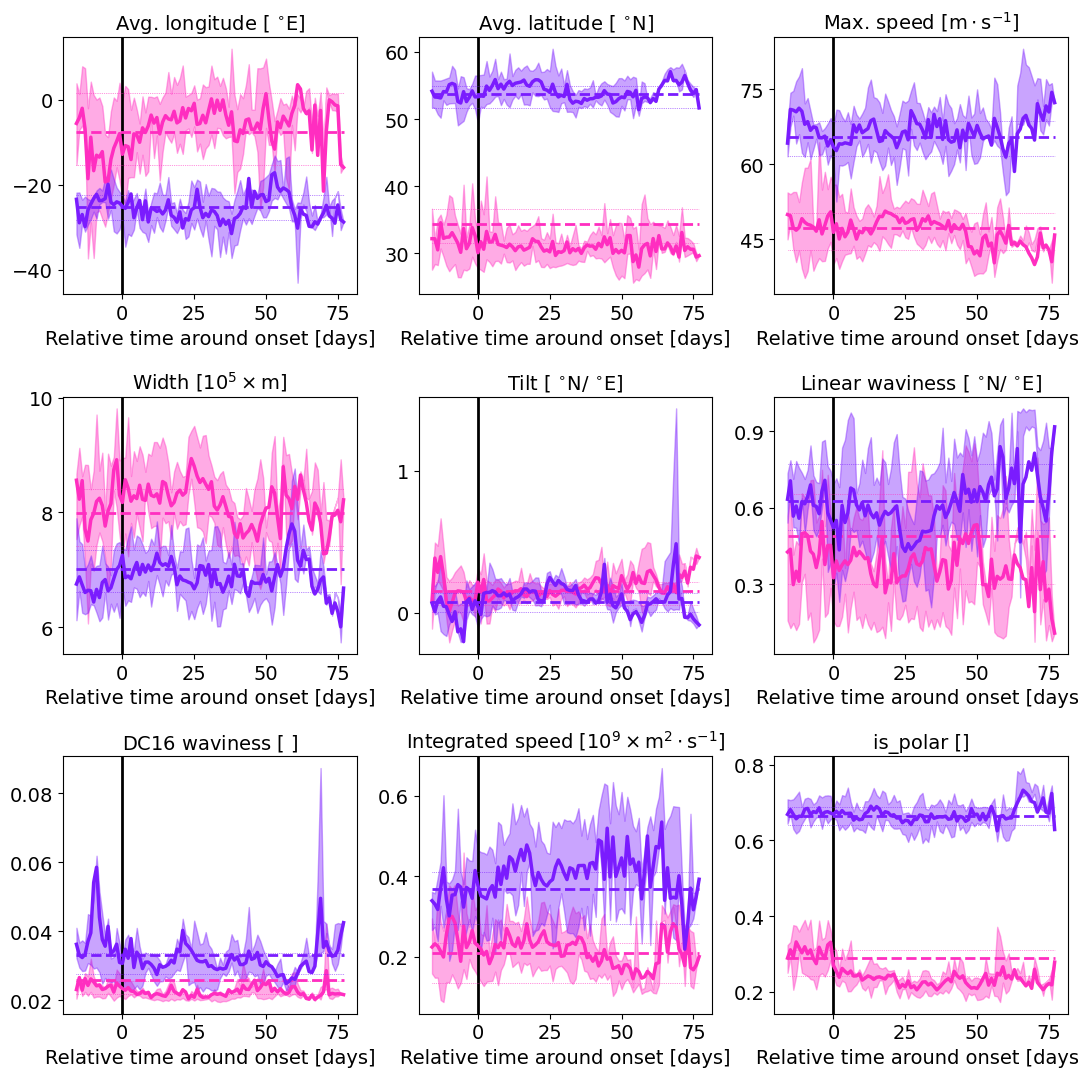

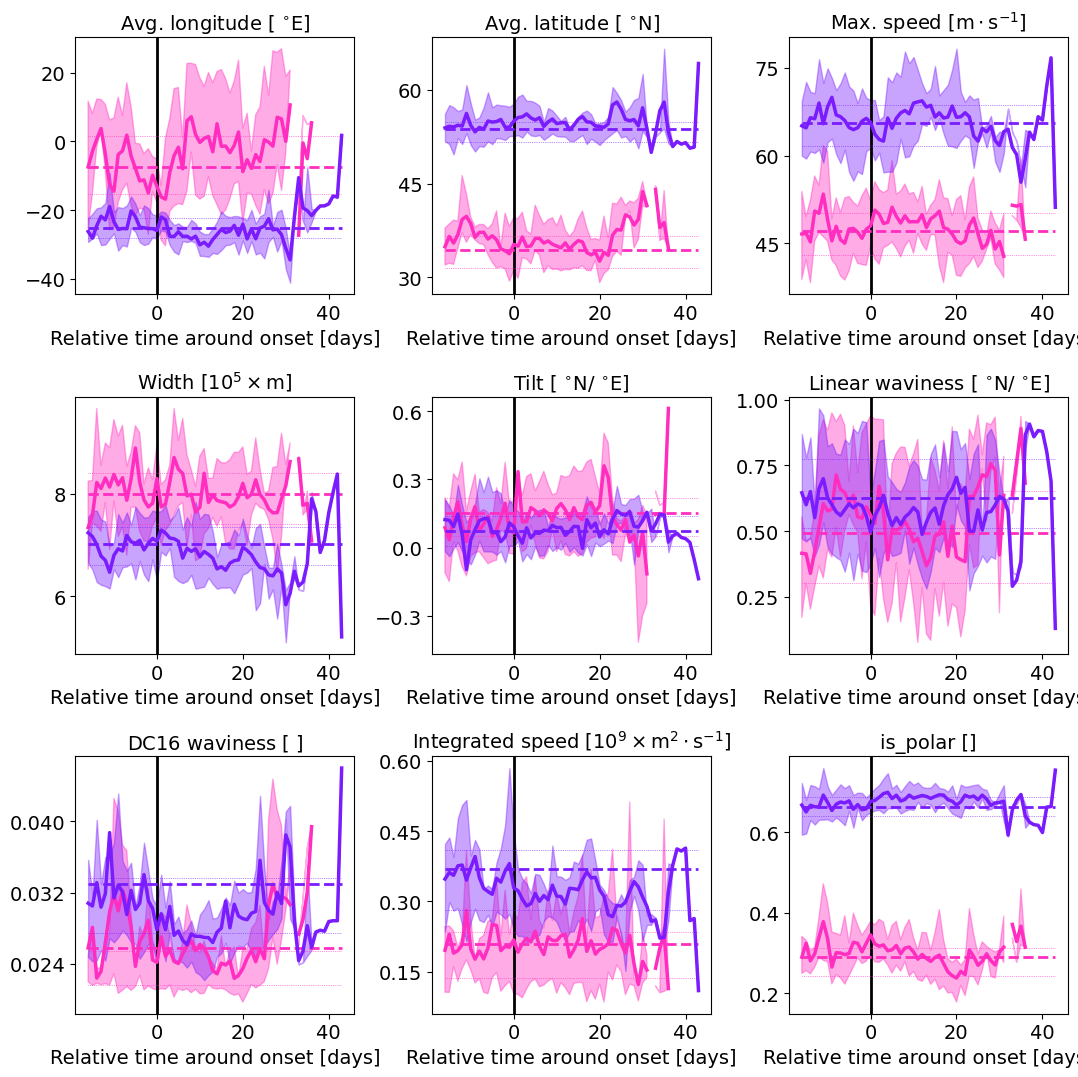

In [37]:
plt.style.use("default")
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("font", size=14)
plt.rc("text", usetex=False)
plt.rc("savefig", dpi=300)
plt.rc("savefig", bbox="tight")

for spell_of in ["STJ" ,"EDJ"]:
    spells_from_jet = spells_list[spell_of]
    props_masked = mask_from_spells_pl(
        spells_from_jet, props_summer, time_before=datetime.timedelta(days=4)
    ).drop("jet").rename({"jet_right": "jet"}).drop("is_polar").rename({"is_polar_right": "is_polar"})
    data_vars = [
        "mean_lon",
        "mean_lat",
        "s_star",
        "width",
        "tilt",
        "waviness1",
        "wavinessDC16",
        "int",
        "is_polar",
    ]
    aggs = {col: pl.col(col).mean() for col in data_vars}
    aggs = aggs | {f"{col}_10": pl.col(col).quantile(0.33) for col in data_vars}
    aggs = aggs | {f"{col}_90": pl.col(col).quantile(0.66) for col in data_vars}
    aggs = aggs | {"alive": pl.col("time").len()}
    mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
    aggs_ = {col: pl.col(col).quantile(0.25) for col in data_vars}
    q25 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs_)
    aggs_ = {col: pl.col(col).quantile(0.75) for col in data_vars}
    q75 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs_)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11), tight_layout=False)
    axes = axes.ravel()
    means = props_summer.group_by("jet", maintain_order=True).agg(**aggs)
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("jet") == jet)
        q25_ = q25.filter(pl.col("jet") == jet)
        q75_ = q75.filter(pl.col("jet") == jet)
        x = to_plot["relative_index"].unique().to_numpy()
        for ax, data_var in zip(axes, data_vars):
            factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
            factor = 1e5 if data_var == "width" else factor
            ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
            ax.fill_between(x, q25_[data_var] / factor, q75_[data_var] / factor, color=COLORS[2 - j], alpha=0.4)
            mean = means.filter(pl.col("jet")==jet)[data_var].item() / factor
            q10 = means.filter(pl.col("jet")==jet)[f"{data_var}_10"].item() / factor
            q90 = means.filter(pl.col("jet")==jet)[f"{data_var}_90"].item() / factor
            ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
            ax.plot([x[0], x[-1]], [q10, q10], color=COLORS[2 - j], ls="dotted", lw=.5)
            ax.plot([x[0], x[-1]], [q90, q90], color=COLORS[2 - j], ls="dotted", lw=.5)
            if j == 0:
                factor_str = "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
                ax.set_title(
                    rf"{PRETTIER_VARNAME.get(data_var, data_var)} [{factor_str}{UNITS.get(data_var, '')}]"
                )
            ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
    for i, ax in enumerate(axes):
        ax.axvline(0, zorder=1, color="black", lw=2)
        ax.set_xlabel("Relative time around onset [days]", color="black")
    print(props_masked["spell"].n_unique())
    fig.set_tight_layout(True)

In [9]:
cross_catd = pl.read_parquet(exp.path.joinpath("cross_catd.parquet"))
props_uncat = exp.props_as_df(False).cast({"time": pl.Datetime("ms")})
props_as_df = average_jet_categories(props_uncat, polar_cutoff=0.45)

cross_catd = cross_catd.with_columns(pers=(pl.col("overlap_max").pow(2) / pl.col("vert_dist").replace(0, 0.1).sqrt()))
cross_catd = cross_catd.filter(pl.col("jet ID") == pl.col("jet ID_right")).with_columns(jet=pl.when(pl.col("jet ID") == 0).then(pl.lit("STJ")).otherwise(pl.lit("EDJ")))
cross_catd_smooth = cross_catd.rolling("time", period="3d", group_by="jet").agg(pl.col("pers").mean().fill_null(0.))

props_as_df = props_as_df.join(cross_catd_smooth.select("time", "jet", "pers"), on=["time", "jet"], how="left").with_columns(pl.col("pers").fill_null(0.))

spells = get_spells(props_as_df, pl.col("pers") > pl.col("pers").quantile(0.975), group_by="jet").sort("jet", "spell")
spells_list = {jet: spells.filter(pl.col("jet") == jet) for jet in spells["jet"].unique()}

In [11]:
spells

spell,jet,len,time,relative_time,start,value,range,relative_index
u32,str,u32,datetime[ms],duration[ms],i64,bool,u32,i32
0,"""EDJ""",17,1960-09-27 06:00:00,0ms,2541,true,2541,0
0,"""EDJ""",17,1960-09-27 12:00:00,6h,2541,true,2542,1
0,"""EDJ""",17,1960-09-27 18:00:00,12h,2541,true,2543,2
0,"""EDJ""",17,1960-09-28 00:00:00,18h,2541,true,2544,3
0,"""EDJ""",17,1960-09-28 06:00:00,1d,2541,true,2545,4
…,…,…,…,…,…,…,…,…
62,"""STJ""",14,2022-08-14 12:00:00,2d 6h,92937,true,92946,9
62,"""STJ""",14,2022-08-14 18:00:00,2d 12h,92937,true,92947,10
62,"""STJ""",14,2022-08-15 00:00:00,2d 18h,92937,true,92948,11


In [ ]:
import altair as alt
alt.data_transformers.enable("vegafusion")
spell_jets = spells_list["EDJ"]
spell_jets = spell_jets.join(all_jets_one_df.filter(pl.col("is_polar") > 0.5), on=["time"])
slider_spell = alt.binding_range(min=spell_jets["spell"].min(), max=spell_jets["spell"].max(), step=1)
spell_value = alt.param("spell", bind=slider_spell, value=0)

slider_rel_time = alt.binding_range(min=spell_jets["relative_index"].min(), max=spell_jets["relative_index"].max(), step=1)
rel_time_value = alt.param("relative_index", bind=slider_rel_time, value=0)

a = (
    alt
    .Chart(spell_jets)
    .mark_point()
    .encode(
        x=alt.X("lon:Q").scale(domain=[-80, 40]),
        y=alt.Y("lat:Q").scale(domain=[20, 80]),
    )
    .transform_filter(
        alt.datum["spell"] == spell_value,
        alt.datum["relative_index"] == rel_time_value,
    )
    .add_params(spell_value, rel_time_value)
)
a

29
23


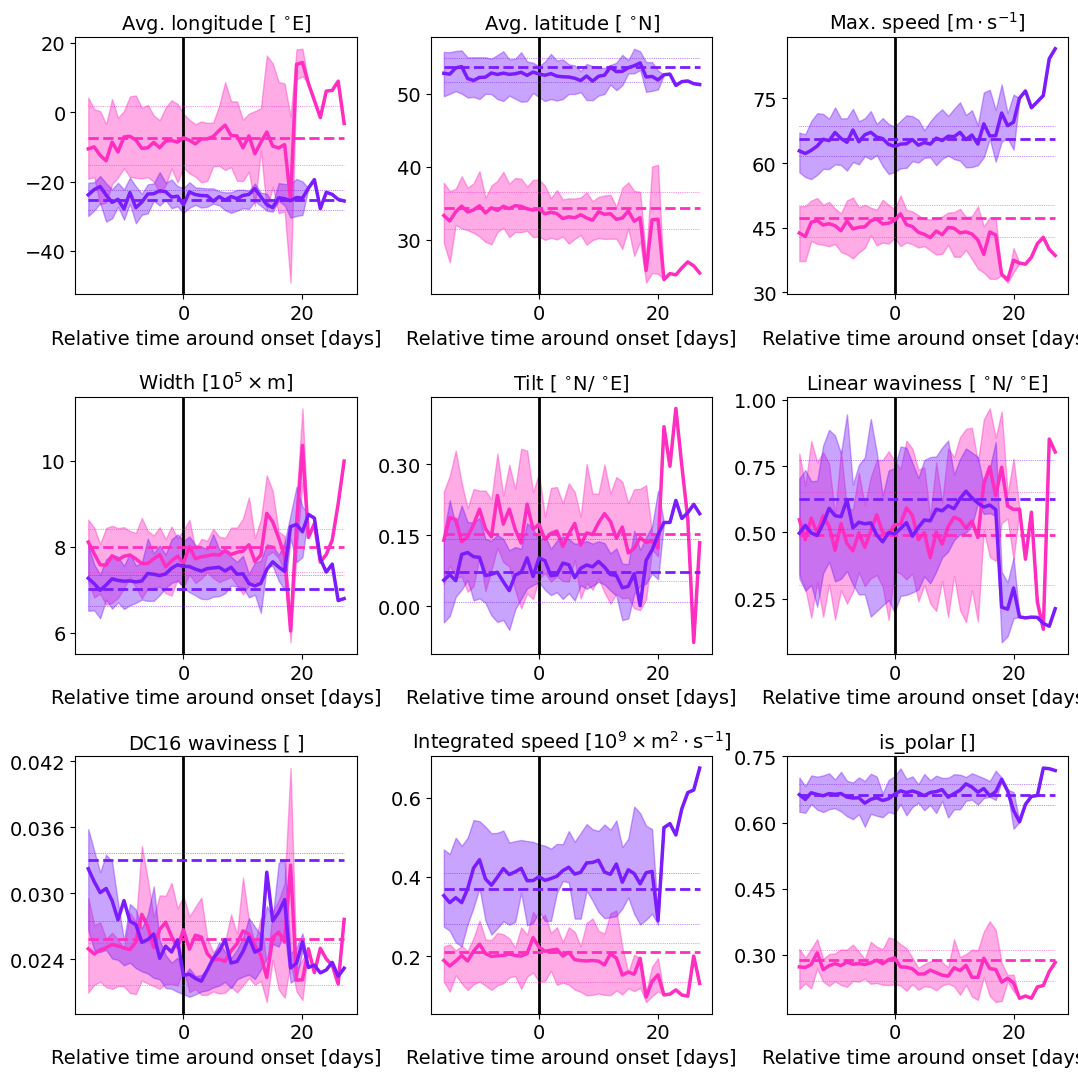

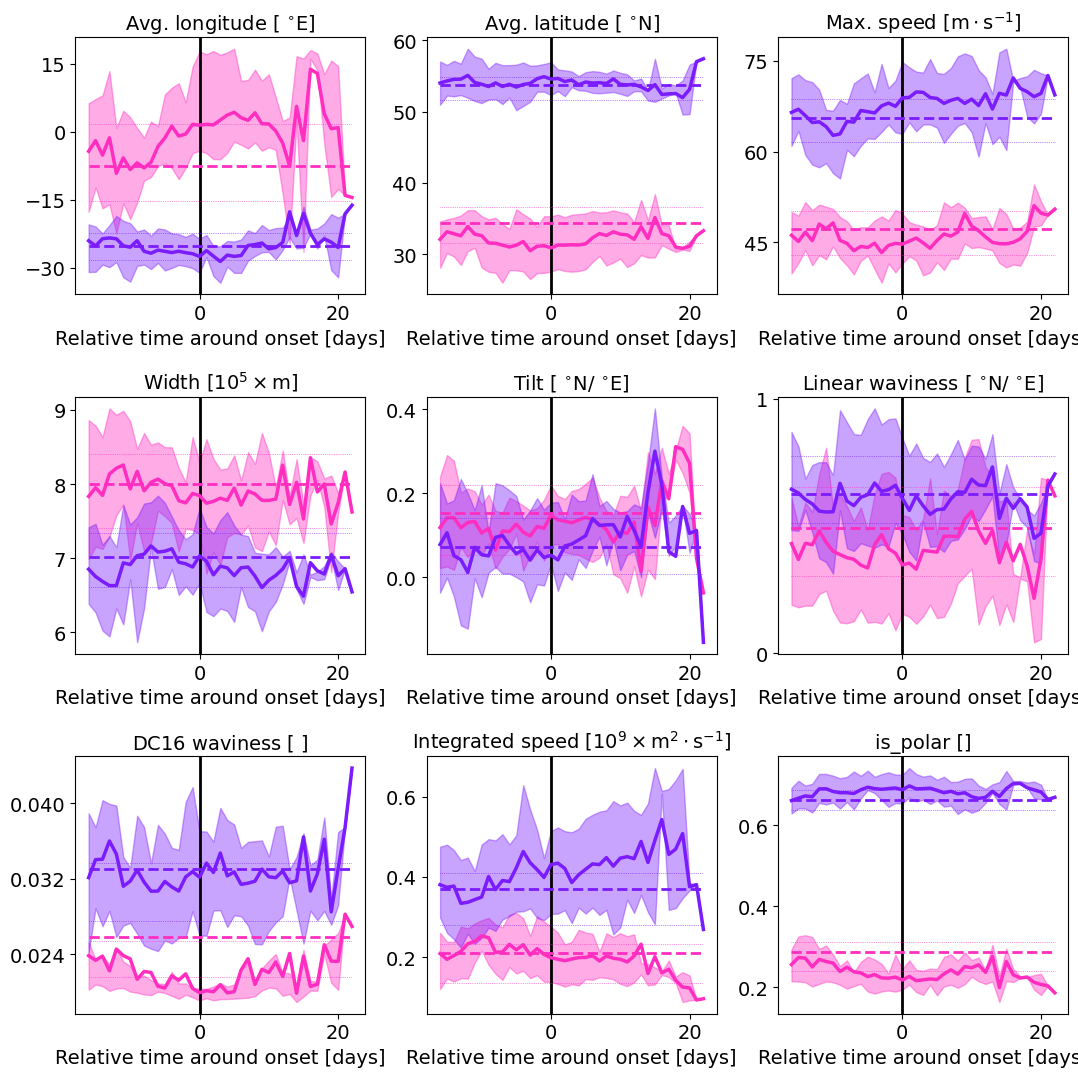

In [25]:
plt.style.use("default")
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("font", size=14)
plt.rc("text", usetex=False)
plt.rc("savefig", dpi=300)
plt.rc("savefig", bbox="tight")

for spell_of in ["STJ" ,"EDJ"]:
    spells_from_jet = spells_list[spell_of]
    props_masked = mask_from_spells_pl(
        spells_from_jet, props_summer, time_before=datetime.timedelta(days=4)
    ).drop("jet").rename({"jet_right": "jet"})
    # ).drop("is_polar").rename({"is_polar_right": "is_polar"})
    data_vars = [
        "mean_lon",
        "mean_lat",
        "s_star",
        "width",
        "tilt",
        "waviness1",
        "wavinessDC16",
        "int",
        "is_polar",
    ]
    aggs = {col: pl.col(col).mean() for col in data_vars}
    aggs = aggs | {f"{col}_10": pl.col(col).quantile(0.33) for col in data_vars}
    aggs = aggs | {f"{col}_90": pl.col(col).quantile(0.66) for col in data_vars}
    aggs = aggs | {"alive": pl.col("time").len()}
    mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
    aggs_ = {col: pl.col(col).quantile(0.25) for col in data_vars}
    q25 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs_)
    aggs_ = {col: pl.col(col).quantile(0.75) for col in data_vars}
    q75 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs_)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11), tight_layout=False)
    axes = axes.ravel()
    means = props_summer.group_by("jet", maintain_order=True).agg(**aggs)
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("jet") == jet)
        q25_ = q25.filter(pl.col("jet") == jet)
        q75_ = q75.filter(pl.col("jet") == jet)
        x = to_plot["relative_index"].unique().to_numpy()
        for ax, data_var in zip(axes, data_vars):
            factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
            factor = 1e5 if data_var == "width" else factor
            ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
            ax.fill_between(x, q25_[data_var] / factor, q75_[data_var] / factor, color=COLORS[2 - j], alpha=0.4)
            mean = means.filter(pl.col("jet")==jet)[data_var].item() / factor
            q10 = means.filter(pl.col("jet")==jet)[f"{data_var}_10"].item() / factor
            q90 = means.filter(pl.col("jet")==jet)[f"{data_var}_90"].item() / factor
            ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
            ax.plot([x[0], x[-1]], [q10, q10], color=COLORS[2 - j], ls="dotted", lw=.5)
            ax.plot([x[0], x[-1]], [q90, q90], color=COLORS[2 - j], ls="dotted", lw=.5)
            if j == 0:
                factor_str = "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
                ax.set_title(
                    rf"{PRETTIER_VARNAME.get(data_var, data_var)} [{factor_str}{UNITS.get(data_var, '')}]"
                )
            ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
    for i, ax in enumerate(axes):
        ax.axvline(0, zorder=1, color="black", lw=2)
        ax.set_xlabel("Relative time around onset [days]", color="black")
    print(props_masked["spell"].n_unique())
    fig.set_tight_layout(True)

# Jet relative stuff

In [26]:
args = ["all", None, *get_region(ds), "all"]
da_T = open_da(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args,
)
da_T = compute(da_T.sel(time=summer_daily), progress_flag=True)
da_T_upper = open_da(
    "ERA5",
    "plev",
    "t300",
    "dailymean",
    *args,
)
da_T_upper = compute(da_T_upper.sel(time=summer_daily), progress_flag=True)
da_tp = open_da(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    *args,
)
da_tp = compute(da_tp.sel(time=summer_daily), progress_flag=True)
da_apvs = open_da(
    "ERA5",
    "thetalev",
    "apvs",
    "dailyany",
    *args,
)
da_apvs = compute(da_apvs.sel(time=summer_daily), progress_flag=True)
da_cpvs = open_da(
    "ERA5",
    "thetalev",
    "cpvs",
    "dailyany",
    *args,
)
da_cpvs = compute(da_cpvs.sel(time=summer_daily), progress_flag=True)

# args = ["all", None, *get_region(ds), "all", "dayofyear", {"dayofyear": ("win", 15)}]
# da_T_anom = open_da(
#     "ERA5",
#     "surf",
#     "t2m",
#     "dailymean",
#     *args
# )
# da_T_anom = compute(da_T_anom.sel(time=summer_daily), progress_flag=True)
# da_tp_anom = open_da(
#     "ERA5",
#     "surf",
#     "tp",
#     "dailysum",
#     *args
# )
# da_tp_anom = compute(da_tp_anom.sel(time=summer_daily), progress_flag=True)

[########################################] | 100% Completed | 57.44 s
[########################################] | 100% Completed | 88.19 s
[########################################] | 100% Completed | 55.89 s
[########################################] | 100% Completed | 7.26 sms
[########################################] | 100% Completed | 8.77 sms


In [38]:
from jetutils.anyspell import make_daily

def symmetrize_p(
    pvals: xr.DataArray | np.ndarray, direction: int, q: float
) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q


def plot_all_relative_composites(jets, times, variable_dict, n_bootstraps: int = 50):
    figs = []
    for varname, props in variable_dict.items():
        if len(props) == 3:
            da, nlevels, cmap = props
            clim = None
        else:
            da, clim, nlevels, cmap = props
        hatch = "xxx" if varname == "tp" else "xx"

        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets, times, da, n_bootstraps=n_bootstraps, clim=clim
        )
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds

        direction = infer_direction(to_plot)
        symmetric = direction == 0

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
            to_plot.quantile(0.01), to_plot.quantile(0.99)
        )
        norm = BoundaryNorm(levels, cmap.N)

        axes[0].pcolormesh(
            to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap
        )
        filter_ = symmetrize_p(pvals[0].T, direction, 0.05)
        axes[0].pcolor(
            pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
        )

        axes[1].pcolormesh(
            to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap
        )
        filter_ = symmetrize_p(pvals[1].T, direction, 0.05)
        axes[1].pcolor(
            pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
        )

        fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
        figs.append(fig)
    return figs


kwargs = dict(time_before=datetime.timedelta(hours=24), time_after=datetime.timedelta(hours=24))

daily_spells_list = {a: make_daily(b.rename({"jet": "spell_of"}), "spell", ["len", "spell_of"]) for a, b in spells_list.items()}
# spells_list = {a: extend_spells(b, **kwargs) for a, b in spells_list.items()}


clims = {
    "t2m": xr.open_dataarray(exp.path.joinpath("t2m_relative_clim.nc")),
    "t_up": xr.open_dataarray(exp.path.joinpath("t300_relative_clim.nc")),
    "tp": xr.open_dataarray(exp.path.joinpath("tp_relative_clim.nc")),
    "apvs" : xr.open_dataarray(exp.path.joinpath("apvs_relative_clim.nc")),
    "cpvs": xr.open_dataarray(exp.path.joinpath("cpvs_relative_clim.nc")),
}

variable_dict = {
    "t2m": [da_T, 8, colormaps.BlWhRe, [-4, 4]],
    "t_up": [da_T_upper, 8, colormaps.BlWhRe, [-4, 4]],
    "tp": [da_tp * 1000, 15, colormaps.precip4_diff_19lev, [-4, 4]],
    "apvs": [da_apvs * 100, 8, colormaps.curl, [-40, 40]],
    "cpvs": [da_cpvs * 100, 8, colormaps.curl, [-40, 40]],
}
long_names = {
    "t2m": "2m temperature [K]",
    "t_up": "Upper level temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
}

plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("font", size=16)
plt.rc("savefig", dpi=300)
from itertools import product

In [40]:
basepath = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")
basepath_clim = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_clims")
import os
for file in basepath.glob("*.nc"):
    os.remove(file)

n_bootstraps = 1
for spells_of in ["STJ", "EDJ"]:
    spells_from_jet = daily_spells_list[spells_of]
    spells_from_jet = extend_spells(spells_from_jet, time_before=datetime.timedelta(days=1))
    spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=1))
    jets = summer_daily.rename("time").to_frame().join(all_jets_one_df, on="time")
    times = spells_from_jet
    for i, (varname, props) in enumerate(variable_dict.items()):
        da, nlevels, cmap, (min_, max_) = props
        clim = clims[varname]
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets.cast({"time": pl.Datetime("ms")}), times, da, n_bootstraps=n_bootstraps, clim=clim
        )
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
            to_plot.to_netcdf(f"/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp/{da.name}_interp_spells_of_{spells_of}.nc")
            pvals.to_netcdf(f"/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp/{da.name}_interp_spells_of_{spells_of}_pvals.nc")
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds
            to_plot.to_netcdf(f"/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp/{da.name}_interp_spells_of_{spells_of}.nc")

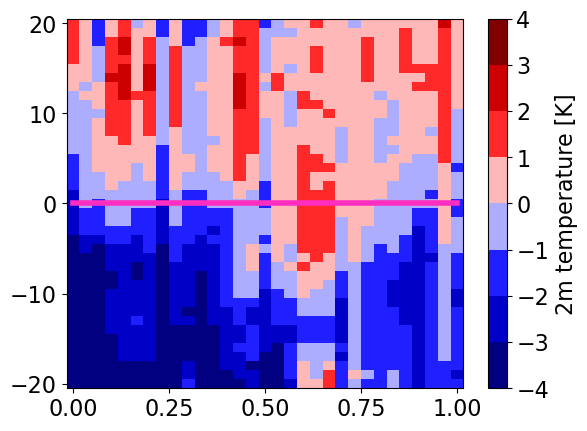

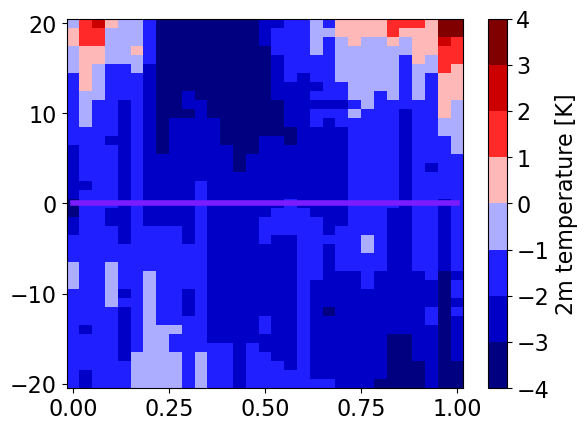

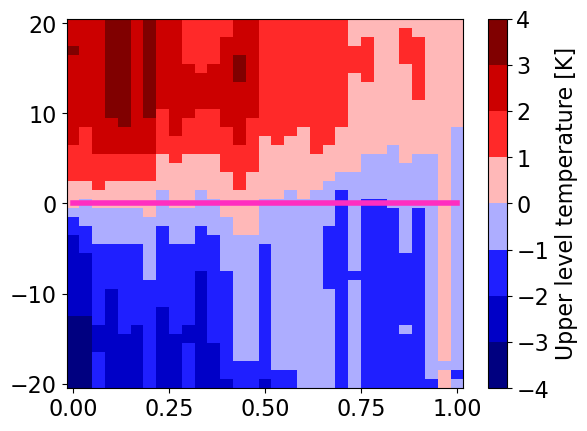

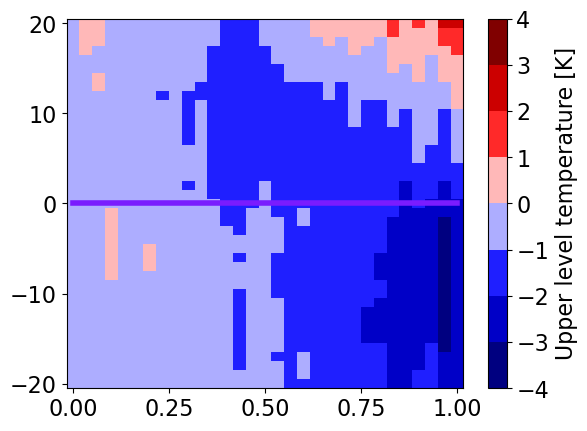

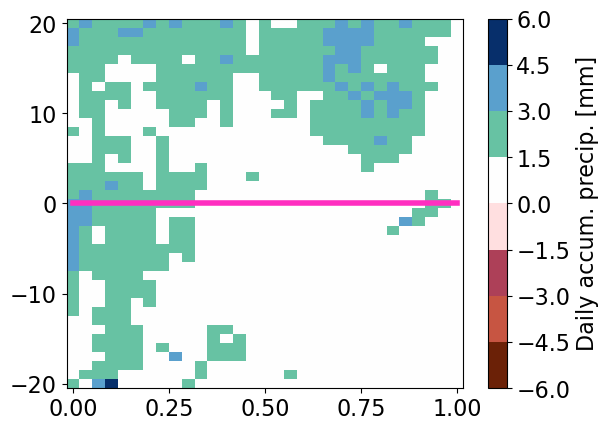

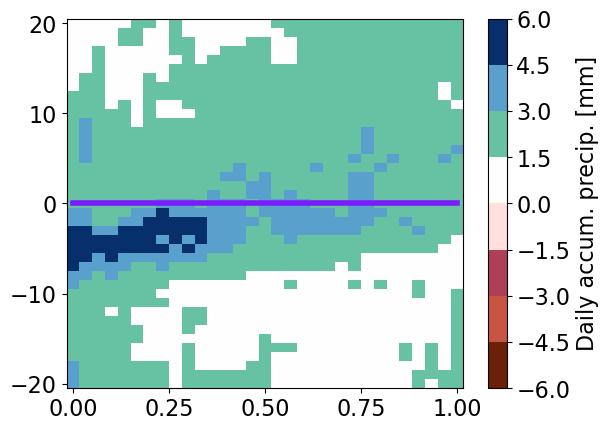

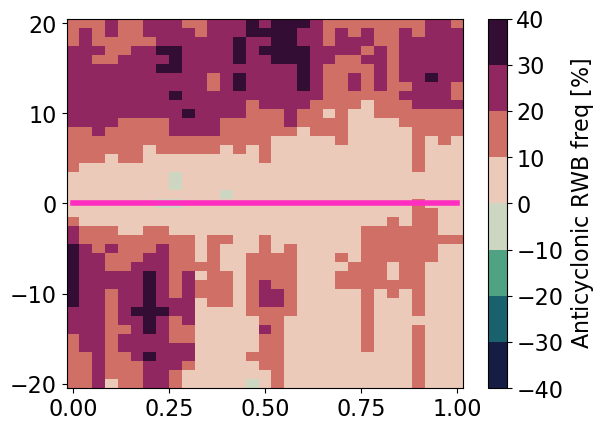

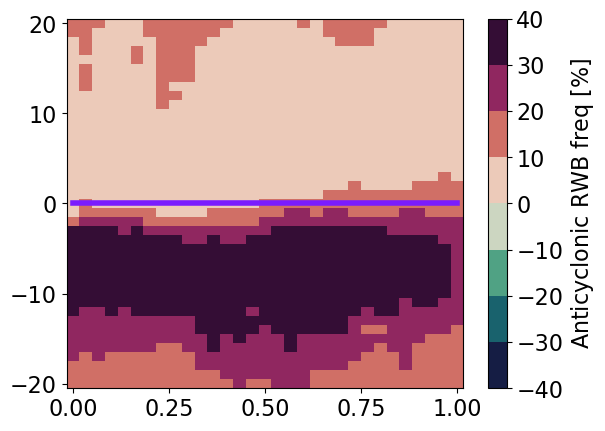

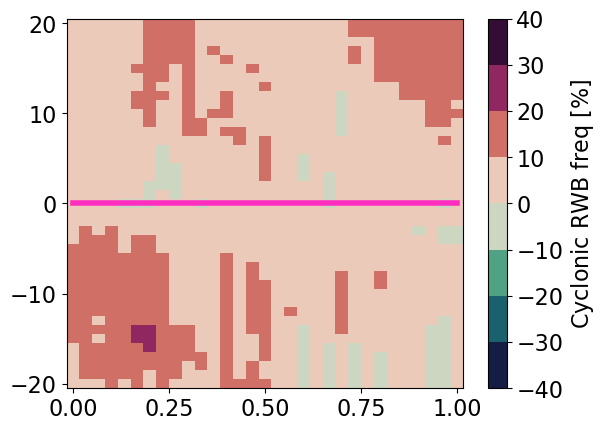

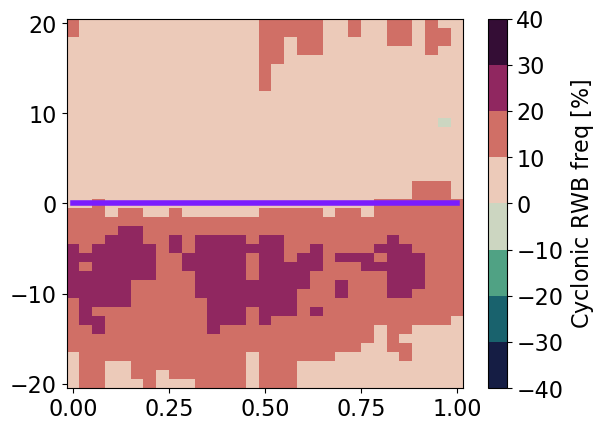

In [41]:
variable_dict = {
    "t2m": ["2m temperature [K]", 8, colormaps.BlWhRe, [-4, 4]],
    "t300": ["Upper level temperature [K]",8, colormaps.BlWhRe, [-4, 4]],
    "tp": ["Daily accum. precip. [mm]", 8, colormaps.precip4_diff_19lev, [-6, 6]],
    "apvs": [r"Anticyclonic RWB freq [$\%$]", 8, colormaps.curl, [-40, 40]],
    "cpvs": [r"Cyclonic RWB freq [$\%$]", 8, colormaps.curl, [-40, 40]],
}
to_plot = {
    varname: [
        xr.open_dataarray(basepath.joinpath(f"{varname}_interp_spells_of_EDJ.nc"), engine="netcdf4"),
        xr.open_dataarray(basepath.joinpath(f"{varname}_interp_spells_of_EDJ_pvals.nc"), engine="netcdf4"),
    ]
    for varname in variable_dict
}
clims = {
    varname: xr.open_dataarray(basepath_clim.joinpath(f"{varname}_relative_clim.nc"))
    for varname in to_plot
}
hatch = "xxx"

for varname in variable_dict:
    long_name, nlevels, cmap, [min_, max_] = variable_dict[varname]
    levels = MaxNLocator(nlevels).tick_values(min_, max_)
    norm = BoundaryNorm(levels, cmap.N)
    for spells_of in ["STJ", "EDJ"]:
        tplt = xr.open_dataarray(basepath.joinpath(f"{varname}_interp_spells_of_{spells_of}.nc"), engine="netcdf4")
        pval = xr.open_dataarray(basepath.joinpath(f"{varname}_interp_spells_of_{spells_of}_pvals.nc"), engine="netcdf4")
        is_polar = spells_of == "EDJ"
        fig, ax = plt.subplots()
        im = ax.pcolormesh(tplt.norm_index, tplt.n, tplt.sel(is_polar=is_polar).values.T, shading="nearest", cmap=cmap, norm=norm)
        direction = infer_direction(tplt.sel(is_polar=is_polar))
        filter_ = symmetrize_p(pval.sel(is_polar=is_polar).T, direction, 0.05)
        # ax.pcolor(pval.norm_index, pval.n, pval.sel(is_polar=is_polar).T.where(filter_), hatch="xxx", alpha=0.0)

        ax.plot([0, 1], [0, 0], lw=4, color=COLORS[2 - int(is_polar)])
        
        fig.colorbar(im, label=long_name)